In [1]:
import pandas as pd
import seaborn as sns

import pyedflib
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
file_name = "./data/chb01_03.edf"
f = pyedflib.EdfReader(file_name)
n = f.signals_in_file
signal_labels = f.getSignalLabels()
sigbufs = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)

In [3]:
sr = 256
batch_size = 64
preictal_time = 20 * 60 * sr

siez_starts = [2996, 1467, 1732, 1015, 1720, 327, 1862]
siez_starts = [siez_starts[i] * sr for i in range(len(siez_starts))]
siez_ends = [3036, 1494, 1772, 1066, 1810, 420, 1963]
siez_ends = [siez_ends[i] * sr for i in range(len(siez_ends))]
file_names = ["chb01_03.edf", "chb01_04.edf", "chb01_15.edf", "chb01_16.edf", "chb01_18.edf", "chb01_21.edf", "chb01_26.edf"]

In [4]:
ch_names = ["FP1-F7",
" F7-T7",
" T7-P7",
" P7-O1",
" FP1-F3",
" F3-C3",
" C3-P3",
" P3-O1",
" FP2-F4",
" F4-C4",
" C4-P4",
" P4-O2",
" FP2-F8",
" F8-T8",
" T8-P8",
" P8-O2",
" FZ-CZ",
" CZ-PZ", 
" P7-T7", " T7-FT9", "FT9-FT10", "FT10-T8","T8-P8"]

In [5]:
data = sigbufs
data = gaussian_filter(data, sigma=3, radius=5)
lstm_train = data[:, :400000]
lstm_test =  data[:, 400000:500000]

mean = lstm_train.mean(axis=1)
std = lstm_train.std(axis=1)
#sigmastest = np.abs(test - mean)
train_norm = (lstm_train - mean[..., None])/std[..., None]
test_norm = (lstm_test - mean[..., None])/std[..., None]

In [6]:
df = pd.DataFrame(lstm_test.transpose(1, 0), columns=ch_names)

Text(0.5, 1.0, 'True Correlation Heatmap')

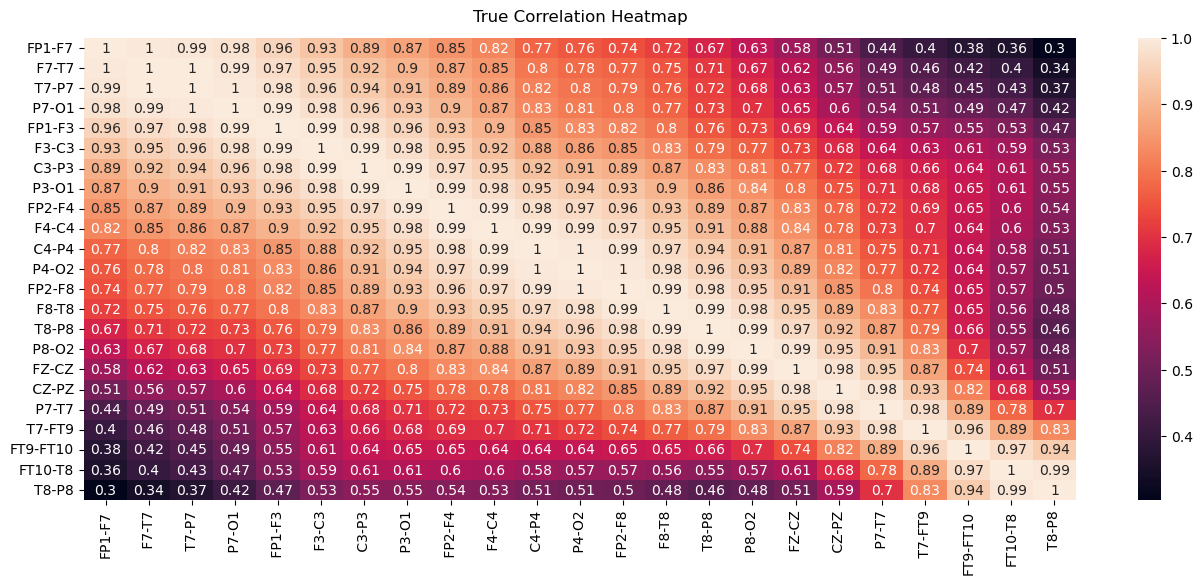

In [7]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), annot=True)
heatmap.set_title('True Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [8]:
df.corr().sum().sum() / 23**2

0.7834697873859797

In [6]:
hiddens = [10, 20, 30, 40, 50]
n_layers = [1, 2]
dropout = [0.1, 0.2]

params = [(h, l, dr) for h in hiddens for l in n_layers for dr in dropout]
rmses = []
mapes = []
exp_names = []
for n_hidden, n_layers, dropout in params:
    exp_name = "_" + str(n_hidden) + "_" + str(n_layers) + "_" + str(dropout)
    rmses.append(np.load("metrics/rmse" + exp_name + ".npy"))
    mapes.append(np.load("metrics/mape" + exp_name+ ".npy"))    
    exp_names.append(exp_name[1:])

In [7]:
baseline_rmses = [0.07490677194876859,
 0.23583275512309188,
 0.5358040698095338,
 1.0307483939157234,
 1.7440694610710354,
 2.6902699869645748,
 3.875562658383471,
 5.291013630815936,
 6.904391045616011,
 8.684723489997186,
 10.598466143265426,
 12.60021561357916,
 14.658476677392512,
 16.744579540766825,
 18.83008870220145,
 20.89444970829646,
 22.917660453775188,
 24.880816942975493,
 26.764555967558813]

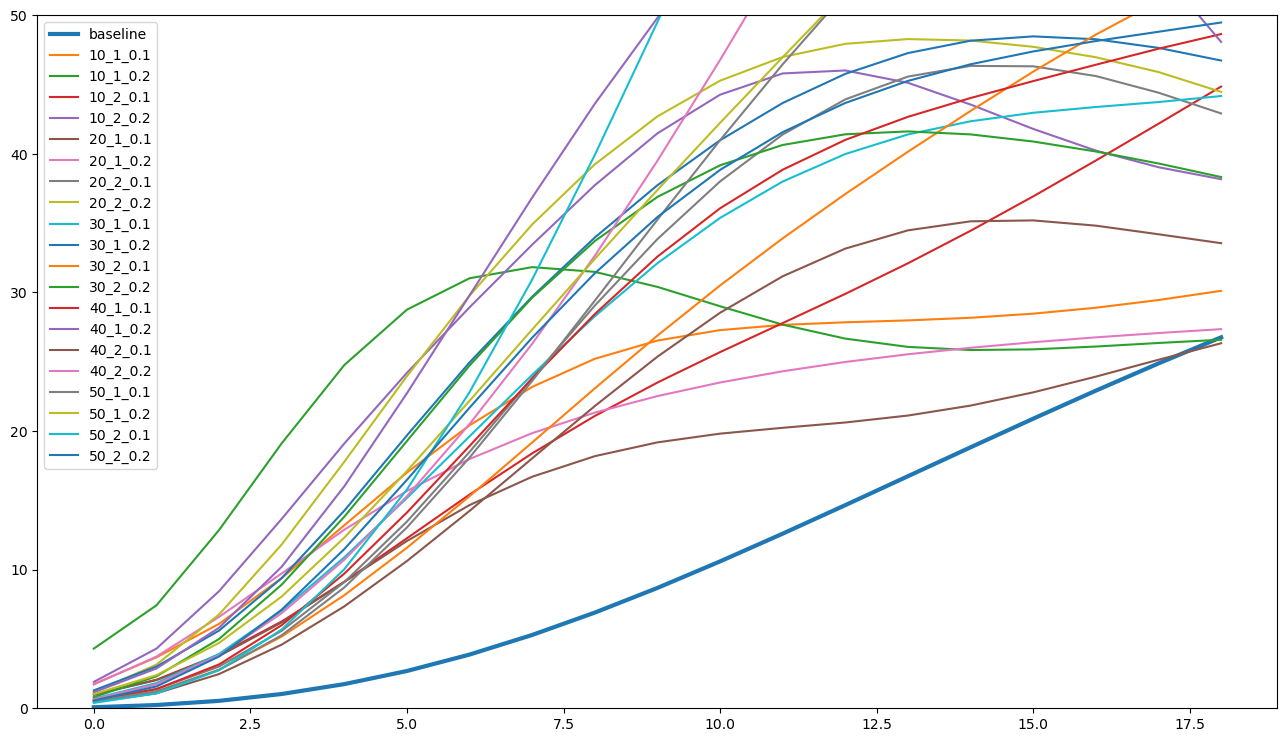

In [30]:
plt.figure(figsize=(16, 9))
plt.plot(baseline_rmses, linewidth=3)
for i in range(len(rmses)):
    plt.plot(rmses[i])
    

plt.ylim([0, 50])
plt.legend(["baseline"] + exp_names)

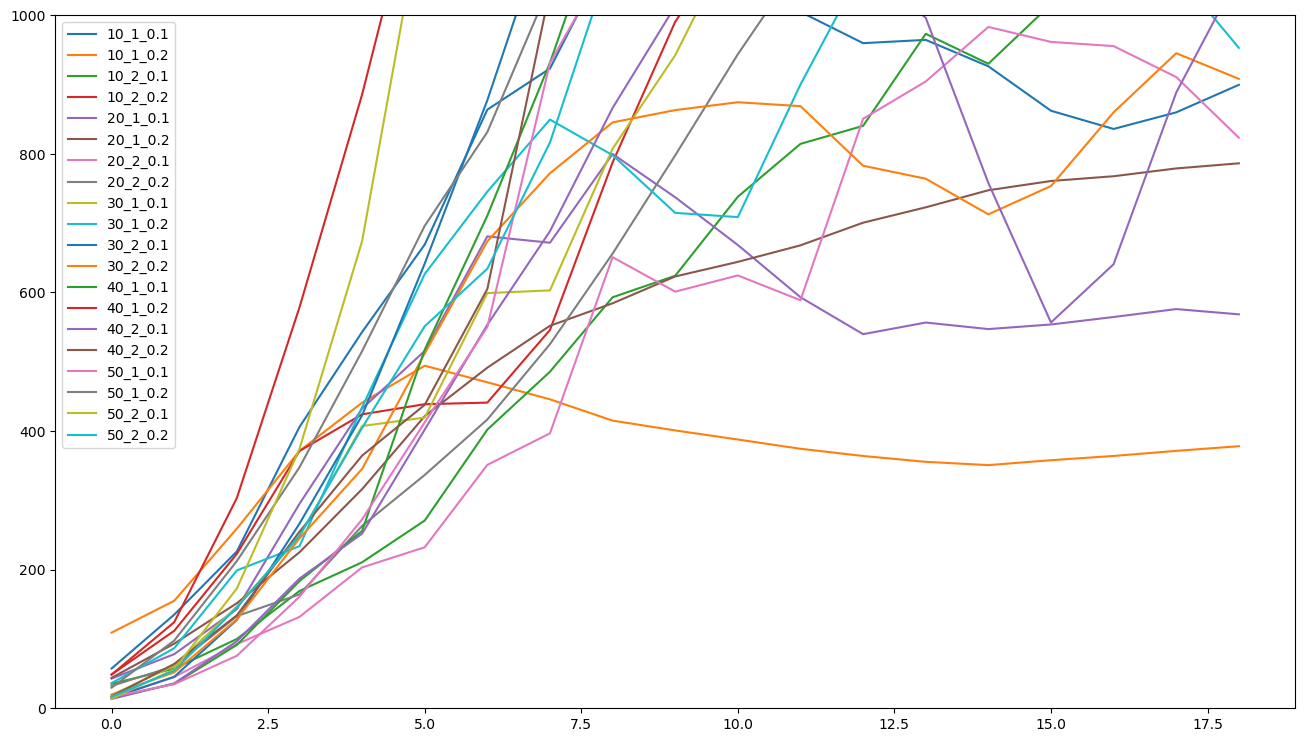

In [23]:
plt.figure(figsize=(16, 9))
for i in range(len(rmses)):
    plt.plot(mapes[i])
    

plt.ylim([0, 1000])
plt.legend(exp_names)

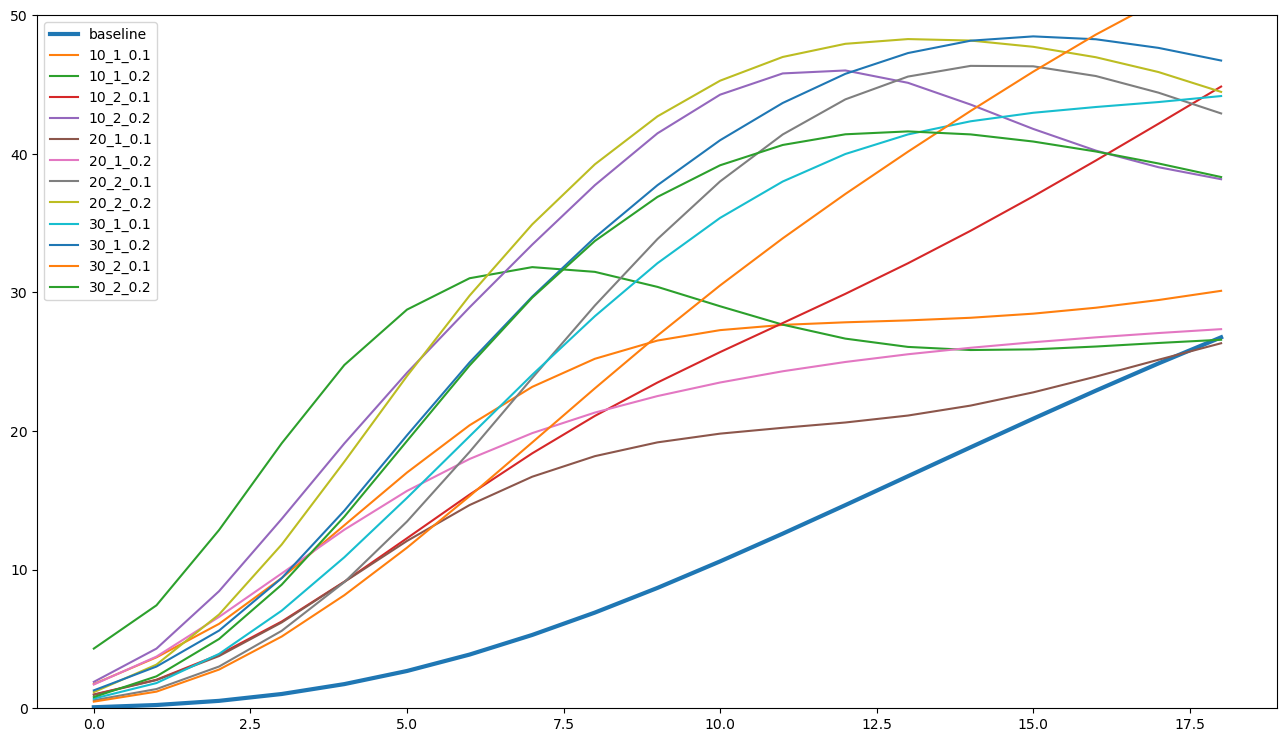

In [35]:
plt.figure(figsize=(16, 9))
plt.plot(baseline_rmses, linewidth=3)
for i in range(len(rmses)//2 + 2):
    plt.plot(rmses[i])
    

plt.ylim([0, 50])
plt.legend(["baseline"] + exp_names)

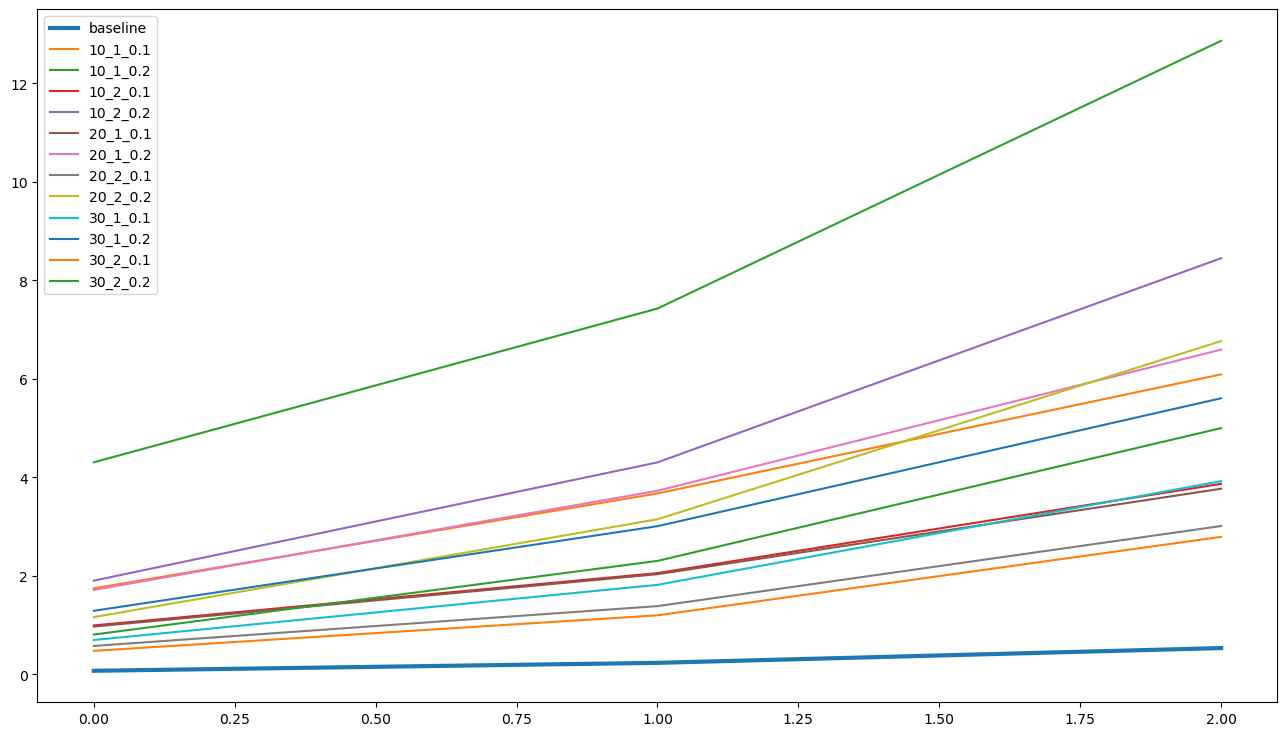

In [34]:
plt.figure(figsize=(16, 9))
plt.plot(baseline_rmses[:3], linewidth=3)
for i in range(len(rmses)//2 + 2):
    plt.plot(rmses[i][:3])
    
plt.legend(["baseline"] + exp_names)

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=baseline_rmses, name="baseline", line=dict(width=5)))
for i in range(len(rmses)):
    fig.add_trace(go.Scatter(y=rmses[i], name=exp_names[i]))
fig.show()

### One of the best 

In [49]:
n_hidden, n_layers, dropout = 30, 2, 0.1

exp_name = "_" + str(n_hidden) + "_" + str(n_layers) + "_" + str(dropout)
lstm_predicts = np.load("./predicts/"+ exp_name +".npy")

In [50]:
def Plt(k):

    
    fig, ax = plt.subplots(figsize = (16, 9))
    ax.plot(lstm_test[0, 20+k-1: 20+k-1 + 1000], linewidth = 3, label='True')
    ax.plot(lstm_predicts[k-1][:1000, 0],  linestyle = (0, (5, 10)), linewidth = 3, label='Predicted', color="red")
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(fontsize=16)
    ax.set_xlabel("t",  fontsize = 16)
    ax.set_ylabel("V, µV",  fontsize = 16)
    ax.set_title('LSTM',  fontsize = 16)
    
    plt.show()
    

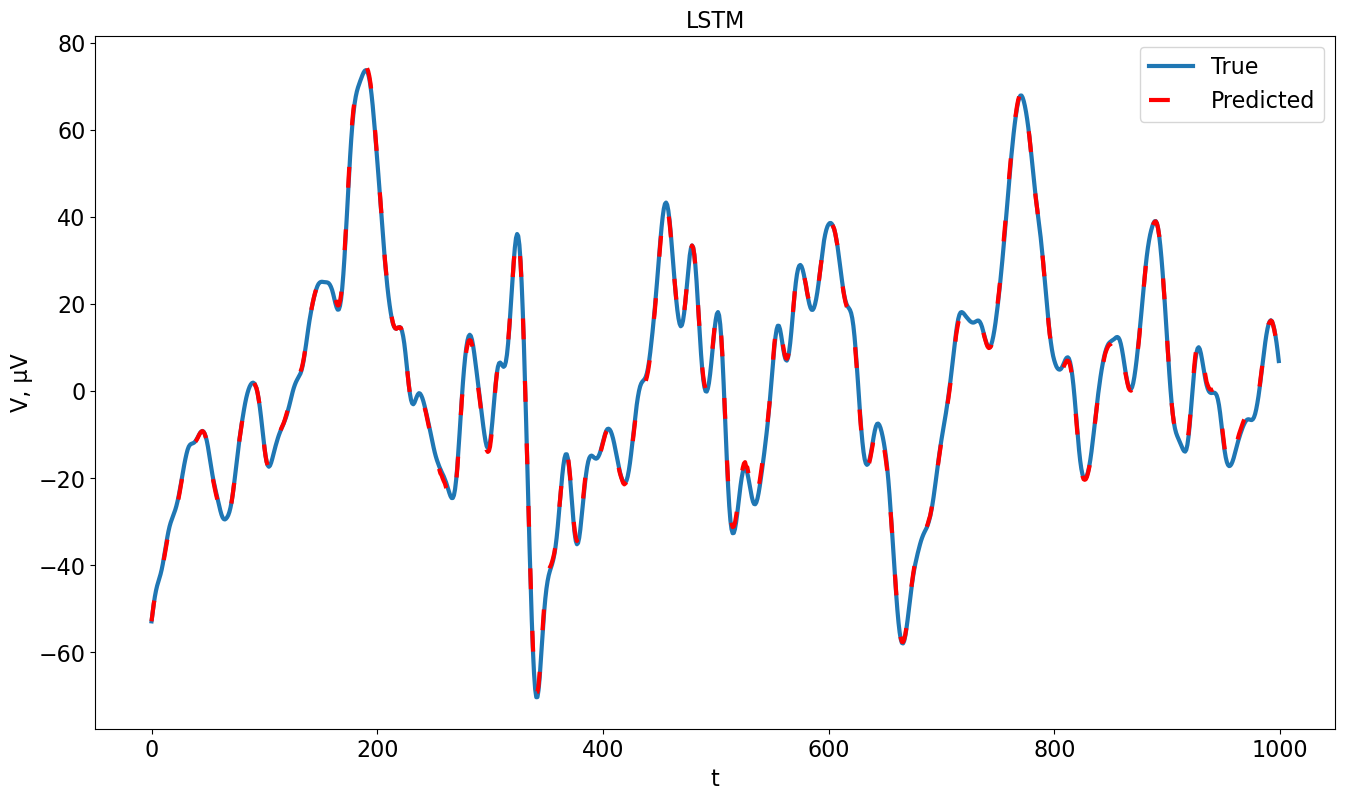

In [51]:
Plt(1)

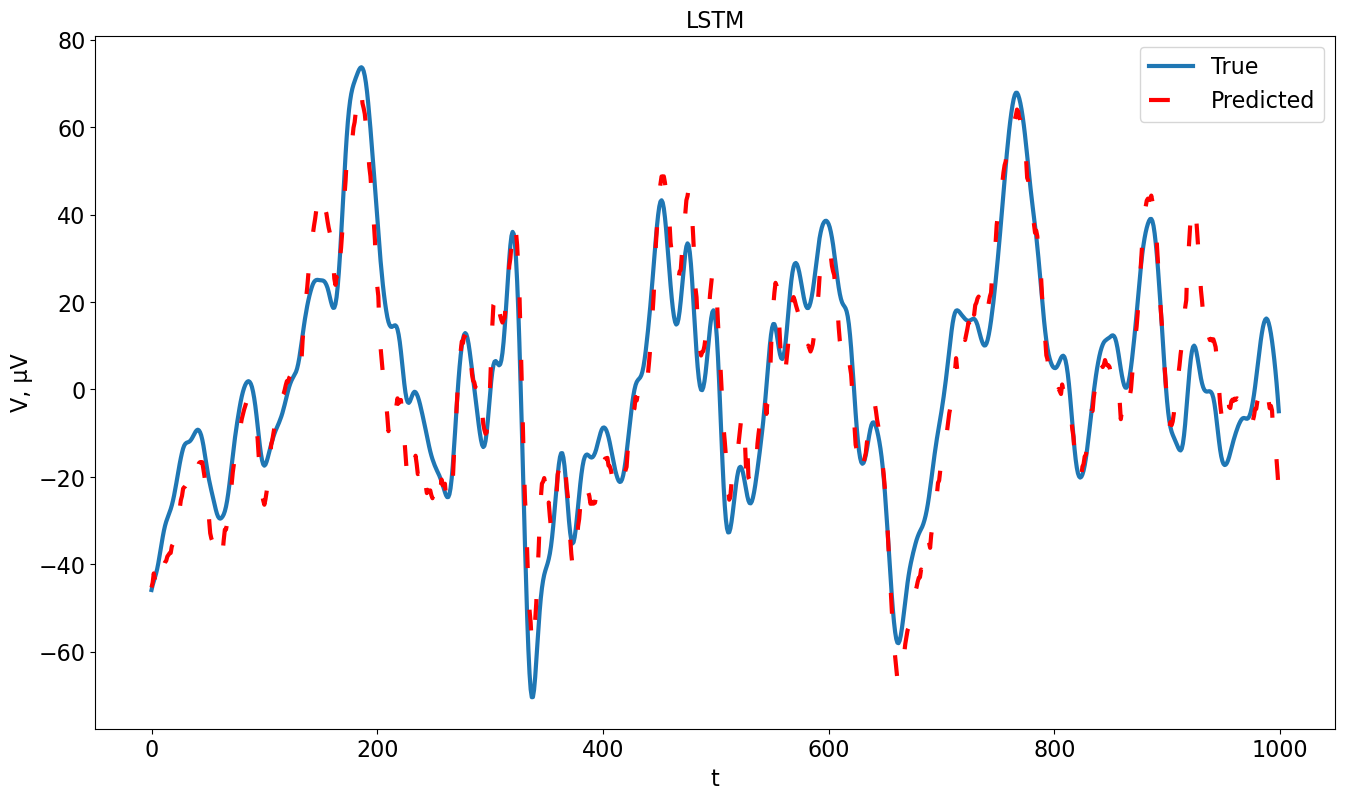

In [52]:
Plt(5)

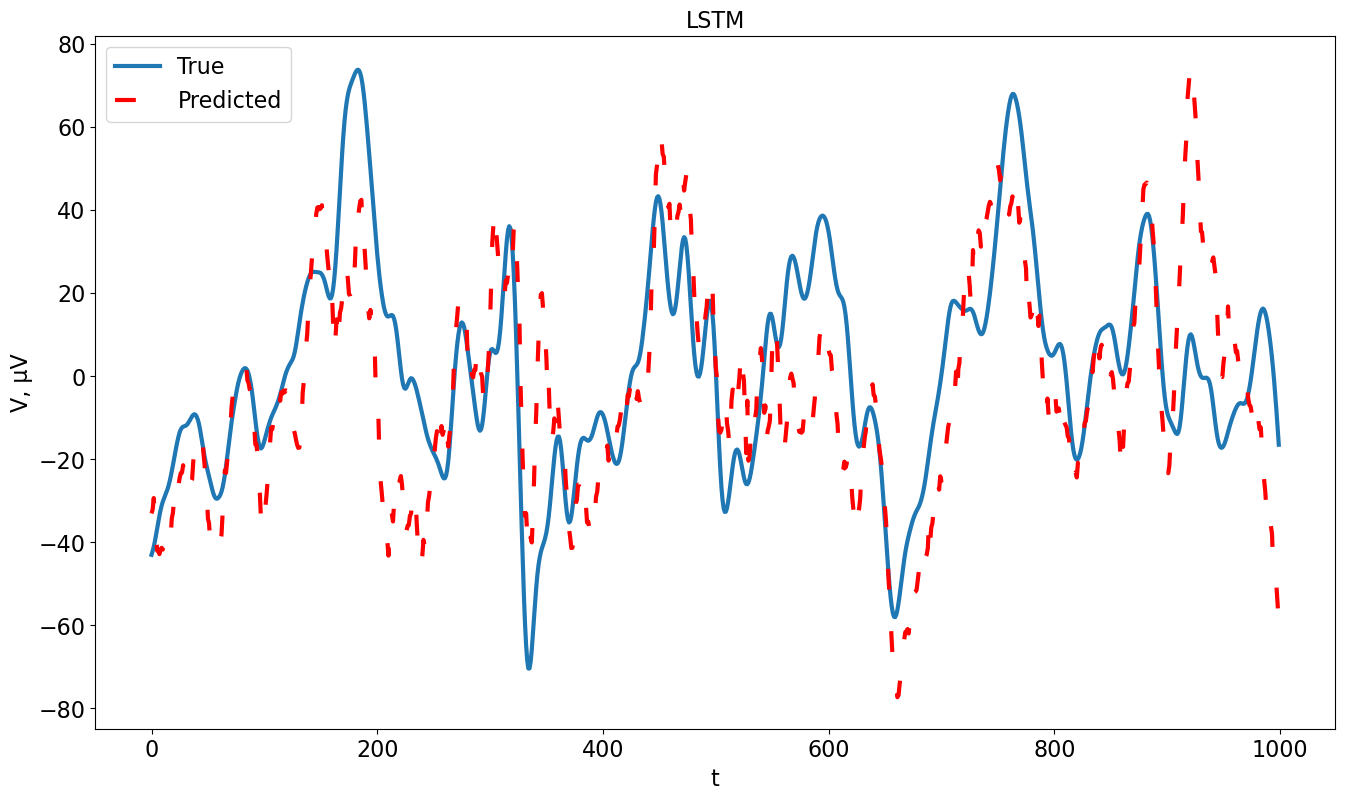

In [53]:
Plt(8)